In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import librosa
# import librosa.display
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio

In [123]:
df_taxonomy = pd.read_csv('birdclef-2025/taxonomy.csv')
df_train_base = pd.read_csv('birdclef-2025/train.csv')

df_all = pd.merge(df_train_base, df_taxonomy[['class_name', 'primary_label']], on='primary_label', how='inner')
train_df = df_all[['primary_label','filename', 'scientific_name', 'class_name','latitude', 'longitude']]
train_df = train_df.copy()

In [ ]:
# aves_labels = train_df.loc[train_df['class_name']=='Aves', 'primary_label'].unique()
# train_df.loc[:,'is_ave'] = train_df['primary_label'].isin(aves_labels)

In [ ]:
# train_df.to_csv('aves/train_aves.csv', index=False) 

In [ ]:
# train_df = train_df.drop(columns=['is_ave'])
# train_df = train_df[train_df['class_name'] != "Aves"]

In [ ]:
# train_df = train_df.copy()
# amphibia_labels = train_df.loc[train_df['class_name']=='Amphibia', 'primary_label'].unique()
# train_df.loc[:,'is_amphibia'] = train_df['primary_label'].isin(amphibia_labels)

In [ ]:
# train_df.to_csv('amphibia/train_amphibia.csv', index=False)

In [ ]:
# train_df = train_df.drop(columns=['is_amphibia'])
# train_df = train_df[train_df['class_name'] != "Amphibia"]

In [ ]:
# train_df = train_df.copy()
# mammalia_labels = train_df.loc[train_df['class_name'] == "Mammalia", "primary_label"].unique()
# train_df.loc[:,'is_mammalia'] = train_df['primary_label'].isin(mammalia_labels)

In [ ]:
# train_df.to_csv('mammalia/train_mammalia.csv', index=False)

In [ ]:
# df_all['class_name'].value_counts()

Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: class_name, dtype: int64

In [ ]:
# train_aves = pd.read_csv('aves/train_aves.csv')
# train_amphibia = pd.read_csv('amphibia/train_amphibia.csv')
# train_mammalia = pd.read_csv('mammalia/train_mammalia.csv')

In [ ]:
# print("Aves", train_aves['is_ave'].value_counts())
# print("Amphibia", train_amphibia['is_amphibia'].value_counts())
# print("Mammalia", train_mammalia['is_mammalia'].value_counts())

Aves True     27648
False      916
Name: is_ave, dtype: int64
Amphibia True     583
False    333
Name: is_amphibia, dtype: int64
Mammalia True     178
False    155
Name: is_mammalia, dtype: int64


In [51]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad') # type: ignore

(get_speech_timestamps, _, read_audio, *_) = utils

def highpass_filter(clean_audio, sr=32000, cutoff=800, order=6):
  import scipy.signal
  nyquist = 0.5 * sr                     
  normal_cutoff = cutoff / nyquist       
  b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False) # type: ignore
  y_filtered = scipy.signal.lfilter(b, a, clean_audio)
  return y_filtered

def _filter_voice(file_path, tramos = False, high_pass= False, audio_base = False):
    
  filename = file_path  
  wav, sr = torchaudio.load(filename)
  # print('Rate: ', sr)
  wav = wav.mean(dim=0)  # convertir a mono si es estéreo

  if audio_base is True:
    # print('Base')
    return wav.numpy()
    
  if tramos is True:
    speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sr)
    non_speech_segments = []
    prev_end = 0

    total_samples = len(wav)
    for ts in speech_timestamps:
      start = ts['start']
      end = ts['end']
        
      if prev_end < start:
        non_speech_segments.append((prev_end, start))
        prev_end = end

    # Si sobra algo al final
    if prev_end < total_samples:
      non_speech_segments.append((prev_end, total_samples))

    # recortar cada segmento:
    clean_audio = (torch.concat([wav[start:end] for start, end in non_speech_segments])).numpy()

  else:
    def fun_clean(wav, sr):
      speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sr)
      if len(speech_timestamps) != 0:

        if speech_timestamps[0]['start']<=100:
          clean_audio = (wav[speech_timestamps[0]['end']:])
        
        else:
          clean_audio = (wav[0:speech_timestamps[0]['start']])
          
      else:
        clean_audio = wav

      return clean_audio
    
    clean_audio = fun_clean(wav=wav, sr=sr)
    clean_audio = fun_clean(wav=clean_audio, sr=sr).numpy()

  if high_pass is True:
    clean_audio = highpass_filter(clean_audio=clean_audio)

  return clean_audio

def ext_chunks(audio_clean, sr, time):
  n_samples = sr * time
  chunks = []
  for i in range(0, len(audio_clean), n_samples):
    start = i
    end = i + n_samples

    if end <= len(audio_clean):
      chunk = audio_clean[start:end]
    else:   
      # padding circular
      faltan = end - len(audio_clean)
      padding = audio_clean[:faltan]
      chunk = np.concatenate([audio_clean[start:], padding])

    chunks.append(chunk)
  return np.array(chunks)

def spectogram(array_audio, n_fft=2048):
    if isinstance(array_audio, np.ndarray):
        # array_audio = array_audio.mean(dim=0) 
        dta = np.abs(librosa.stft(array_audio, n_fft=n_fft))
        D = librosa.amplitude_to_db(dta, ref=np.max)
    else:
        # wav = array_audio.mean(dim=0) 
        dta = np.abs(librosa.stft(array_audio.numpy()))
        D = librosa.amplitude_to_db(dta, ref=np.max)
    return D


def _extract_features(audio, sr=32000):

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)
    mfccs_var = mfccs.var(axis=1)

    # Spectral Centroid
    sc = librosa.feature.spectral_centroid(y=audio, sr=sr)
    sc_mean = sc.mean()
    sc_var = sc.var()

    # Spectral Bandwidth 
    bw = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    bw_mean = bw.mean()
    bw_var = bw.var()

    # Spectral Rolloff 
    srf = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    srf_mean = srf.mean()
    srf_var = srf.var()

    # Spectral Flux 
    sf = librosa.onset.onset_strength(y=audio, sr=sr)  # proxy para flux
    sf_mean = sf.mean()
    sf_var = sf.var()

    # Spectral Flatness 
    sfm = librosa.feature.spectral_flatness(y=audio)
    sfm_mean = sfm.mean()
    sfm_var = sfm.var()

    # Zero Crossing Rate 
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    zcr_mean = zcr.mean()
    zcr_var = zcr.var()

    # RMS Energy 
    rms = librosa.feature.rms(y=audio)
    rms_mean = rms.mean()
    rms_var = rms.var()

    # Vector final
    features = np.concatenate([
        mfccs_mean, mfccs_var,
        [sc_mean, sc_var],
        [bw_mean, bw_var],
        [srf_mean, srf_var],
        [sf_mean, sf_var],
        [sfm_mean, sfm_var],
        [zcr_mean, zcr_var],
        [rms_mean, rms_var]
    ])

    return features
# Nombres de las columnas
mfcc_cols = [f'mfcc_{i+1}_mean' for i in range(13)] + [f'mfcc_{i+1}_var' for i in range(13)]
extra_cols = [
    'spec_centroid_mean', 'spec_centroid_var',
    'spec_bandwidth_mean', 'spec_bandwidth_var',
    'rolloff_mean', 'rolloff_var',
    'flux_mean', 'flux_var',
    'flatness_mean', 'flatness_var',
    'zcr_mean', 'zcr_var',
    'rms_mean', 'rms_var'
]
column_names = mfcc_cols + extra_cols


Using cache found in C:\Users\overm/.cache\torch\hub\snakers4_silero-vad_master


In [131]:
filename=train_df[train_df['class_name'] == 'Insecta']['filename']
id = f'birdclef-2025/train_audio/{filename.iloc[1]}'
clean_audio = _filter_voice(file_path=id,  tramos=False, high_pass=True)
# clean_audio = highpass_filter(clean_audio)
chunks = ext_chunks(audio_clean=clean_audio, sr=32000, time=5)
# futures = _extract_features(audio=chunks[0], sr=32000)

In [134]:
sp=spectogram(chunks[1])

sp = (sp - np.mean(sp)) / np.std(sp)

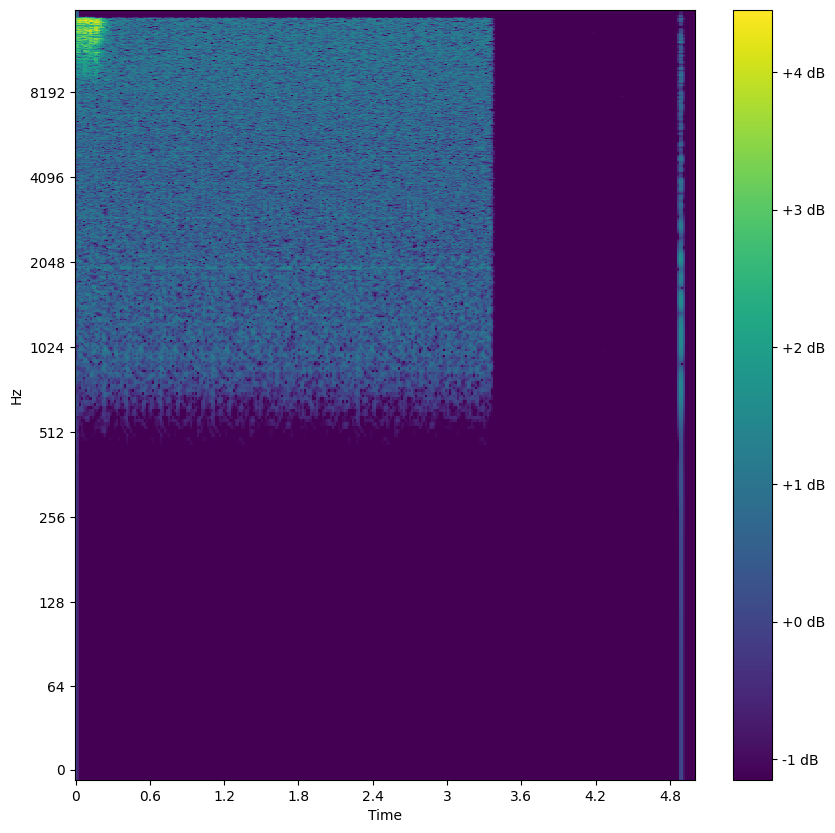

In [135]:
plt.figure(figsize=(10, 10))
librosa.display.specshow(sp, sr=32000, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [172]:
import os
def process_audio_file(row, sr=32000, chunk_duration=5, max_chunks=3, 
                       tramos=False, apply_highpass=True, audio_base = False):

    filename = row['filename']
    scientific_name = row['scientific_name']
    class_name = row['class_name']  

    audio_path = f'birdclef-2025/train_audio/{filename}'

    try:
        # Preprocesamiento
        clean_audio = _filter_voice(file_path=audio_path, tramos=tramos, high_pass=apply_highpass, audio_base=audio_base)
        chunks = ext_chunks(audio_clean=clean_audio, sr=sr, time=chunk_duration)

        data = []
        specs, labels = [], []


        for i, chunk in enumerate(chunks):
            feats = _extract_features(chunk, sr=sr)
            data.append(feats)

            if class_name != "Aves":
                S_dB = spectogram(chunk)
                label = scientific_name  
                label = scientific_name.replace(" ", "_").replace("/", "_")


                # Carpeta por clase
                save_dir = f"{class_name}/NPZ/"
                # os.makedirs(save_dir, exist_ok=True)

                name = os.path.splitext(os.path.basename(filename))[0]

                unique_id = f"{name}_chunk{i}"

                save_path = os.path.join(save_dir, f"{label}_{unique_id}.npz")

                np.savez_compressed(save_path, spec=S_dB, label=label, class_name=class_name)

        df = pd.DataFrame(data, columns=column_names)
        df['class_name'] = class_name

        return df

    except Exception as e:
        print(f"Error procesando {filename}: {e}")
        return pd.DataFrame()  


In [173]:
aves_df = train_df[train_df['class_name'] == "Aves"]
aves_sampled = aves_df.groupby('scientific_name').apply(lambda x: x.sample(n=6, random_state=42)) \
                     .reset_index(drop=True)

no_aves_df = train_df[train_df['class_name'] != "Aves"]
train = pd.concat([aves_sampled, no_aves_df], ignore_index=True)
train['class_name'].value_counts()

Aves        876
Amphibia    583
Mammalia    178
Insecta     155
Name: class_name, dtype: int64

In [ ]:
import warnings
warnings.filterwarnings('ignore')
id_labels = train #subset_df[['filename', 'is_ave', 'scientific_name', 'class_name']]
full_data = []
count = 0
for i, row in id_labels.iterrows():
    df_chunk = process_audio_file(row, tramos= True, audio_base=False, apply_highpass=True)
    if not df_chunk.empty:
        full_data.append(df_chunk)
    count+=1
    # if row['class_name'] != "Aves":
    #     break
    print(count)

df_all = pd.concat(full_data, ignore_index=True).round(3)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [ ]:
df_all.to_csv('M1.csv', index=False)

In [ ]:
df = pd.read_csv('M1.csv')

In [180]:
df['class_name'].value_counts()

Aves        6453
Amphibia    3833
Insecta     3604
Mammalia    1291
Name: class_name, dtype: int64

##### Separator (Deezer)
Esto logra separar perfectamente la voz humana y el resto lo cataloga como ruido, sin embargo, parecido a silero-vad, el audo de ruido tendría la especie y las respiraciones humanas. Sin embargo, de fondo de ruido, se alcanza a escuchar el eco de la grabación, correspondiente a la voz humana

In [15]:
# from spleeter.separator import Separator

# id = f'birdclef-2025/train_audio/{filename.iloc[1]}'

# # Inicializa el modelo de 2 fuentes
# separator = Separator('spleeter:2stems')

# # Separar el archivo
# separator.separate_to_file(id, 'output')


In [16]:
# wav, sr = torchaudio.load('output\\CSA36389\\accompaniment.wav')
# wav = wav.mean(dim=0) 
# dta = np.abs(librosa.stft(wav.numpy()))
# new = librosa.amplitude_to_db(dta, ref=np.max)

# plt.figure(figsize=(10, 5))

# librosa.display.specshow(new, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
# plt.title("Filtrado (Highpass)")
# plt.colorbar(format='%+2.0f dB')

# plt.tight_layout()
# plt.show()
# display(Audio('output\\CSA36389\\accompaniment.wav'))

In [17]:
# wav, sr = torchaudio.load('output\\CSA36389\\vocals.wav')
# wav = wav.mean(dim=0) 
# dta = np.abs(librosa.stft(wav.numpy()))
# new = librosa.amplitude_to_db(dta, ref=np.max)

# plt.figure(figsize=(10, 5))

# librosa.display.specshow(new, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
# plt.title("Filtrado (Highpass)")
# plt.colorbar(format='%+2.0f dB')

# plt.tight_layout()
# plt.show()
# display(Audio('output\\CSA36389\\vocals.wav'))